In [2]:
# Installing the PyMC Marketing library
!pip install pymc_marketing

In [3]:
!pip install openpyxl

In [2]:
# Importing required libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from arviz.labels import MapLabeller

from IPython.display import Image
from pymc_marketing import clv

import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import ModifiedBetaGeoFitter

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


In [3]:
# Setting the style of the plots
# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading and Preprocessing

In [9]:
import requests
import zipfile
import os

# Download the zip file
# url = "https://archive.ics.uci.edu/static/public/352/online+retail.zip"
# response = requests.get(url)
filename = "online_retail.zip"

# with open(filename, 'wb') as file:
#     file.write(response.content)

# Unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("online_retail_data")

# Finding the Excel file name
for file in os.listdir("online_retail_data"):
    if file.endswith(".xlsx"):
        excel_file = os.path.join("online_retail_data", file)
        break

# Convert from Excel to CSV
data_raw = pd.read_excel(excel_file)

data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
# Handling Return Orders
# Extracting rows where InvoiceNo starts with "C"
cancelled_orders = data_raw[data_raw['InvoiceNo'].astype(str).str.startswith("C")]

# Create a temporary DataFrame with the columns we want to match on, and also negate the 'Quantity' column
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']

# Merge the original DataFrame with the temporary DataFrame on the columns we want to match
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']], 
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'], 
                       how='left', indicator=True)

# Filter out rows where the merge found a match, and also filter out the original return orders
data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['InvoiceNo'].astype(str).str.startswith("C"))]

# Drop the indicator column
data_raw = data_raw.drop(columns=['_merge'])


In [11]:
# Selecting relevant features and calculating total sales
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

# Removing transactions with missing customer IDs as they don't contribute to individual customer behavior
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
print(data.shape)
data.head()

(392695, 7)


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,17850,536365,2010-12-01 08:26:00,6,2.55,United Kingdom,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,United Kingdom,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34


In [12]:
# Checking for missing values
pd.DataFrame(zip(data.isnull().sum(), data.isnull().sum()/len(data)), columns=['Count', 'Proportion'], index=data.columns)

,Count,Proportion
CustomerID,0,0.0
InvoiceNo,0,0.0
InvoiceDate,0,0.0
Quantity,0,0.0
UnitPrice,0,0.0
Country,0,0.0
TotalSales,0,0.0


In [13]:
# Summarizing the dataset's content to understand its scope
maxdate = data['InvoiceDate'].dt.date.max()
mindate = data['InvoiceDate'].dt.date.min()
unique_cust = data['CustomerID'].nunique()
tot_quantity = data['Quantity'].sum()
tot_sales = data['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4326
Total Quantity Sold: 4913316
Total Sales for the period: 8391630.964


In [33]:
data = pd.read_csv('/Users/changyu/Downloads/manifest.csv')
print(data.shape)
data.head()

(4762028, 3)


,customer_id,consume_num,create_time
0,27226,60.0,2019-10-23 15:22:52
1,33376,30.0,2019-10-18 17:27:37
2,28924,30.0,2019-10-15 11:00:34
3,6889,30.0,2019-10-16 13:49:03
4,9720,30.0,2019-10-25 10:56:06


In [65]:
data_summary_rfm = clv.utils.rfm_summary(data, 'customer_id', 'create_time', 'consume_num')
data_summary_rfm = data_summary_rfm[data_summary_rfm['frequency']>0]
data_summary_rfm.head()

,customer_id,frequency,recency,T,monetary_value
0,4889,225.0,1890.0,2046.0,61.044444
2,4920,295.0,2039.0,2047.0,63.322034
3,4952,1386.0,1745.0,1746.0,275.937951
5,4967,39.0,1274.0,1276.0,81.410256
6,4979,832.0,2160.0,2162.0,62.391827


In [64]:
# Here, we prepare a summary from transaction data, transforming individual transaction data into data at the customer level.

# data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = clv.utils.rfm_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
data_summary_rfm.head()

KeyError: 'InvoiceDate'

In [15]:
# data_summary_rfm = data_summary_rfm[data_summary_rfm['monetary_value'] > 0]

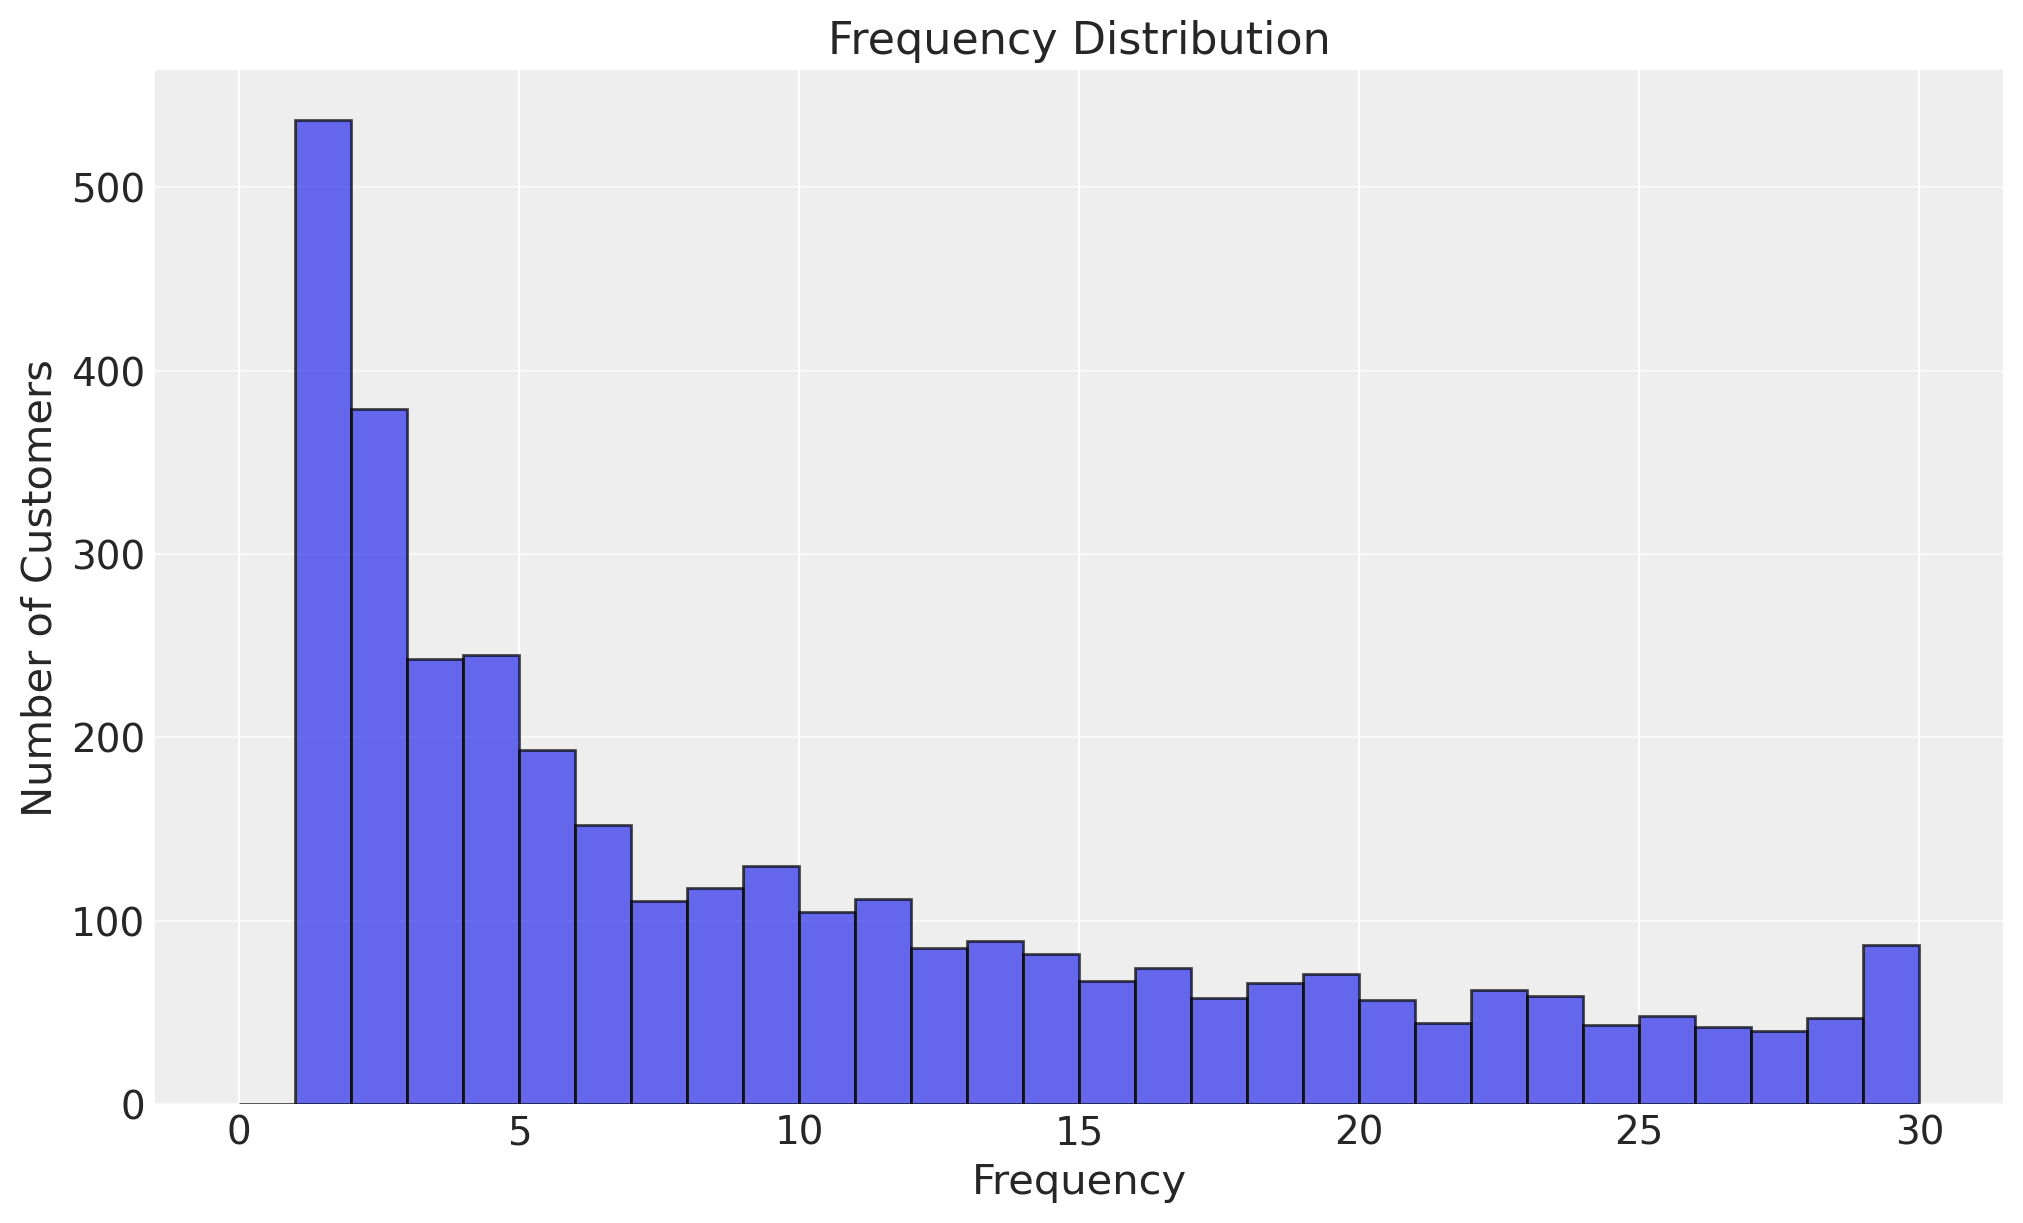

Percentage of customers who purchased only once: 6.71%


In [66]:
# Plotting the frequency distribution of customers
plt.figure(figsize=(10, 6))
plt.hist(data_summary_rfm['frequency'], bins=30, range=[0, 30], edgecolor='k', alpha=0.7)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

one_time = round(sum(data_summary_rfm['frequency'] == 1) / float(len(data_summary_rfm)) * 100, 2)
print(f"Percentage of customers who purchased only once: {one_time}%")


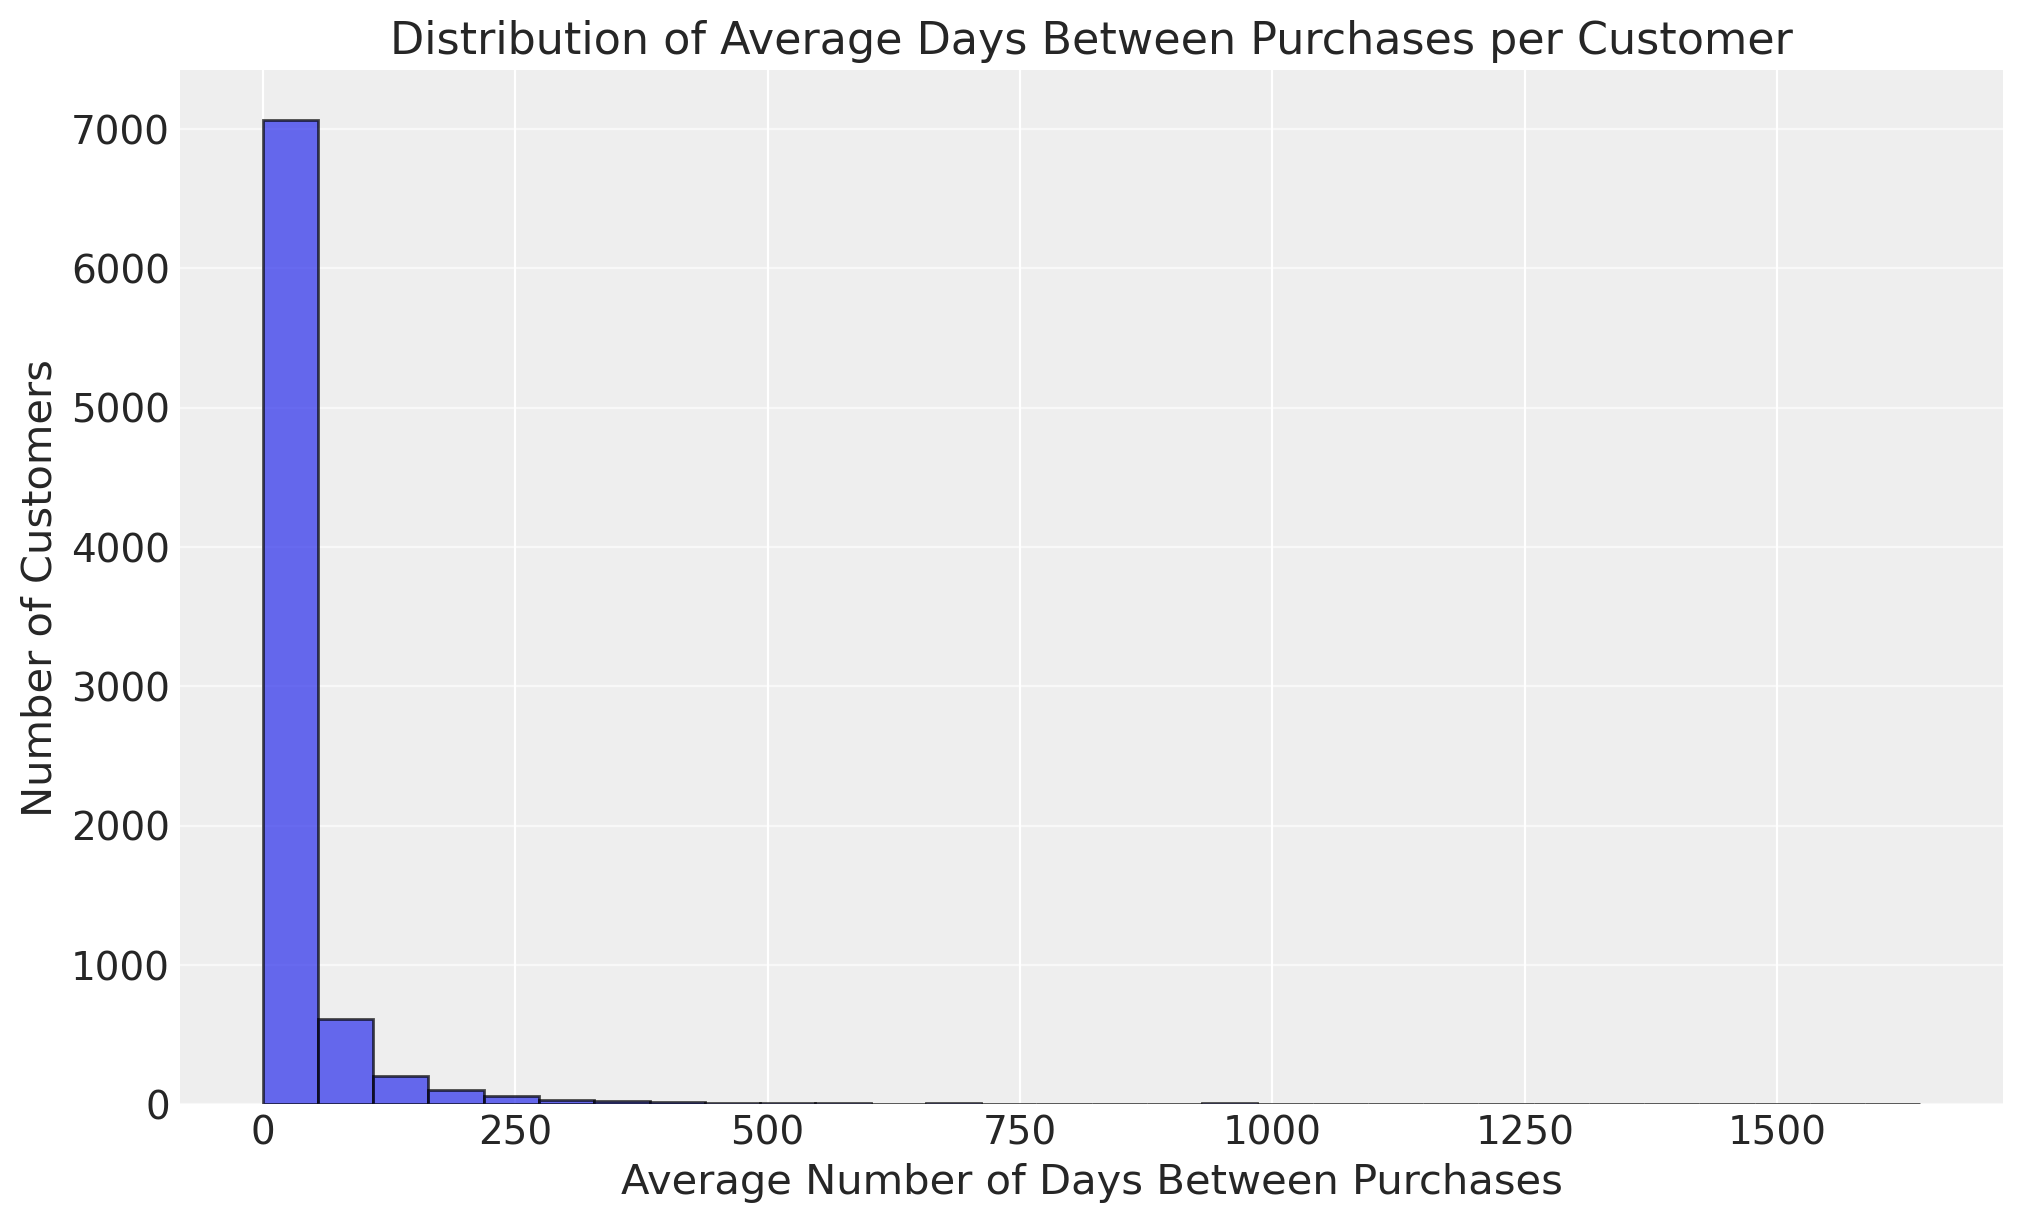

In [67]:
# Calculating Days Between Purchases

# Select distinct CustomerID and InvoiceDate
data['create_time'] = pd.to_datetime(data['create_time'])
unique_purchases = data[['customer_id', 'create_time']].drop_duplicates()

# Sorting values to ensure the calculation of the difference correctly
unique_purchases = unique_purchases.sort_values(['customer_id', 'create_time'])

# Calculating the difference in days between current and next purchase
unique_purchases['NextInvoiceDate'] = unique_purchases.groupby('customer_id')['create_time'].shift(-1)
unique_purchases['DaysBetween'] = (unique_purchases['NextInvoiceDate'] - unique_purchases['create_time']).dt.days

# Calculating Average Days
customer_avg_days = unique_purchases.groupby('customer_id')['DaysBetween'].mean().dropna()

# Plotting the Histogram
plt.figure(figsize=(10, 6))
plt.hist(customer_avg_days, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Average Days Between Purchases per Customer')
plt.xlabel('Average Number of Days Between Purchases')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

In [9]:
# Calculating Days Between Purchases

# Select distinct CustomerID and InvoiceDate
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
unique_purchases = data[['CustomerID', 'InvoiceDate']].drop_duplicates()

# Sorting values to ensure the calculation of the difference correctly
unique_purchases = unique_purchases.sort_values(['CustomerID', 'InvoiceDate'])

# Calculating the difference in days between current and next purchase
unique_purchases['NextInvoiceDate'] = unique_purchases.groupby('CustomerID')['InvoiceDate'].shift(-1)
unique_purchases['DaysBetween'] = (unique_purchases['NextInvoiceDate'] - unique_purchases['InvoiceDate']).dt.days

# Calculating Average Days
customer_avg_days = unique_purchases.groupby('CustomerID')['DaysBetween'].mean().dropna()

# Plotting the Histogram
plt.figure(figsize=(10, 6))
plt.hist(customer_avg_days, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Average Days Between Purchases per Customer')
plt.xlabel('Average Number of Days Between Purchases')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()



KeyError: 'InvoiceDate'

In [68]:
data_summary_rfm

,customer_id,frequency,recency,T,monetary_value
0,4889,225.0,1890.0,2046.0,61.044444
2,4920,295.0,2039.0,2047.0,63.322034
3,4952,1386.0,1745.0,1746.0,275.937951
5,4967,39.0,1274.0,1276.0,81.410256
6,4979,832.0,2160.0,2162.0,62.391827
...,...,...,...,...,...
9112,1931964247059566593,1.0,4.0,5.0,35.000000
9113,1932006964305170433,2.0,5.0,5.0,135.000000
9114,1932035018616315906,1.0,2.0,5.0,35.000000
9115,1932282446858788866,2.0,8.0,8.0,315.000000


# Another Dataset

In [89]:
data_path = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/clv_quickstart.csv"
df = pd.read_csv(data_path)
df.head()

,frequency,recency,T,monetary_value
0,2,30.43,38.86,22.35
1,1,1.71,38.86,11.77
2,0,0.00,38.86,0.00
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00


In [90]:
data_summary_rfm = (
    df.reset_index()
    .rename(columns={"index": "customer_id"})
    .drop(columns="monetary_value")
)

In [69]:
# Initializing the MBG/NBD model.
mbgm = clv.ModifiedBetaGeoModel(data=data_summary_rfm)
mbgm.build_model()
mbgm


MBG/NBD
            alpha ~ Weibull(2, 10)
                r ~ Weibull(2, 1)
      phi_dropout ~ Uniform(0, 1)
    kappa_dropout ~ Pareto(1, 1)
                a ~ Deterministic(f(kappa_dropout, phi_dropout))
                b ~ Deterministic(f(kappa_dropout, phi_dropout))
recency_frequency ~ ModifiedBetaGeoNBD(a, b, r, alpha, <constant>)

In [70]:
sample_kwargs = {
    "draws": 2_000,
    "chains": 4,
    "target_accept": 0.9,
    "random_seed": 42,
}
idata_mcmc = mbgm.fit(**sample_kwargs)
idata_mcmc

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, r, phi_dropout, kappa_dropout]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 87 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [72]:
mbgm.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.290,0.083,4.139,4.453,0.001,0.001,4332.0,4341.0,1.0
r,0.701,0.010,0.683,0.719,0.000,0.000,4488.0,4513.0,1.0
phi_dropout,0.019,0.001,0.017,0.020,0.000,0.000,4012.0,4255.0,1.0
kappa_dropout,6.233,0.453,5.399,7.082,0.007,0.006,3851.0,3968.0,1.0
a,0.116,0.004,0.108,0.123,0.000,0.000,5821.0,5698.0,1.0
b,6.117,0.450,5.295,6.969,0.007,0.006,3848.0,3906.0,1.0


### Visualizing the MBG/NBD Model Trace

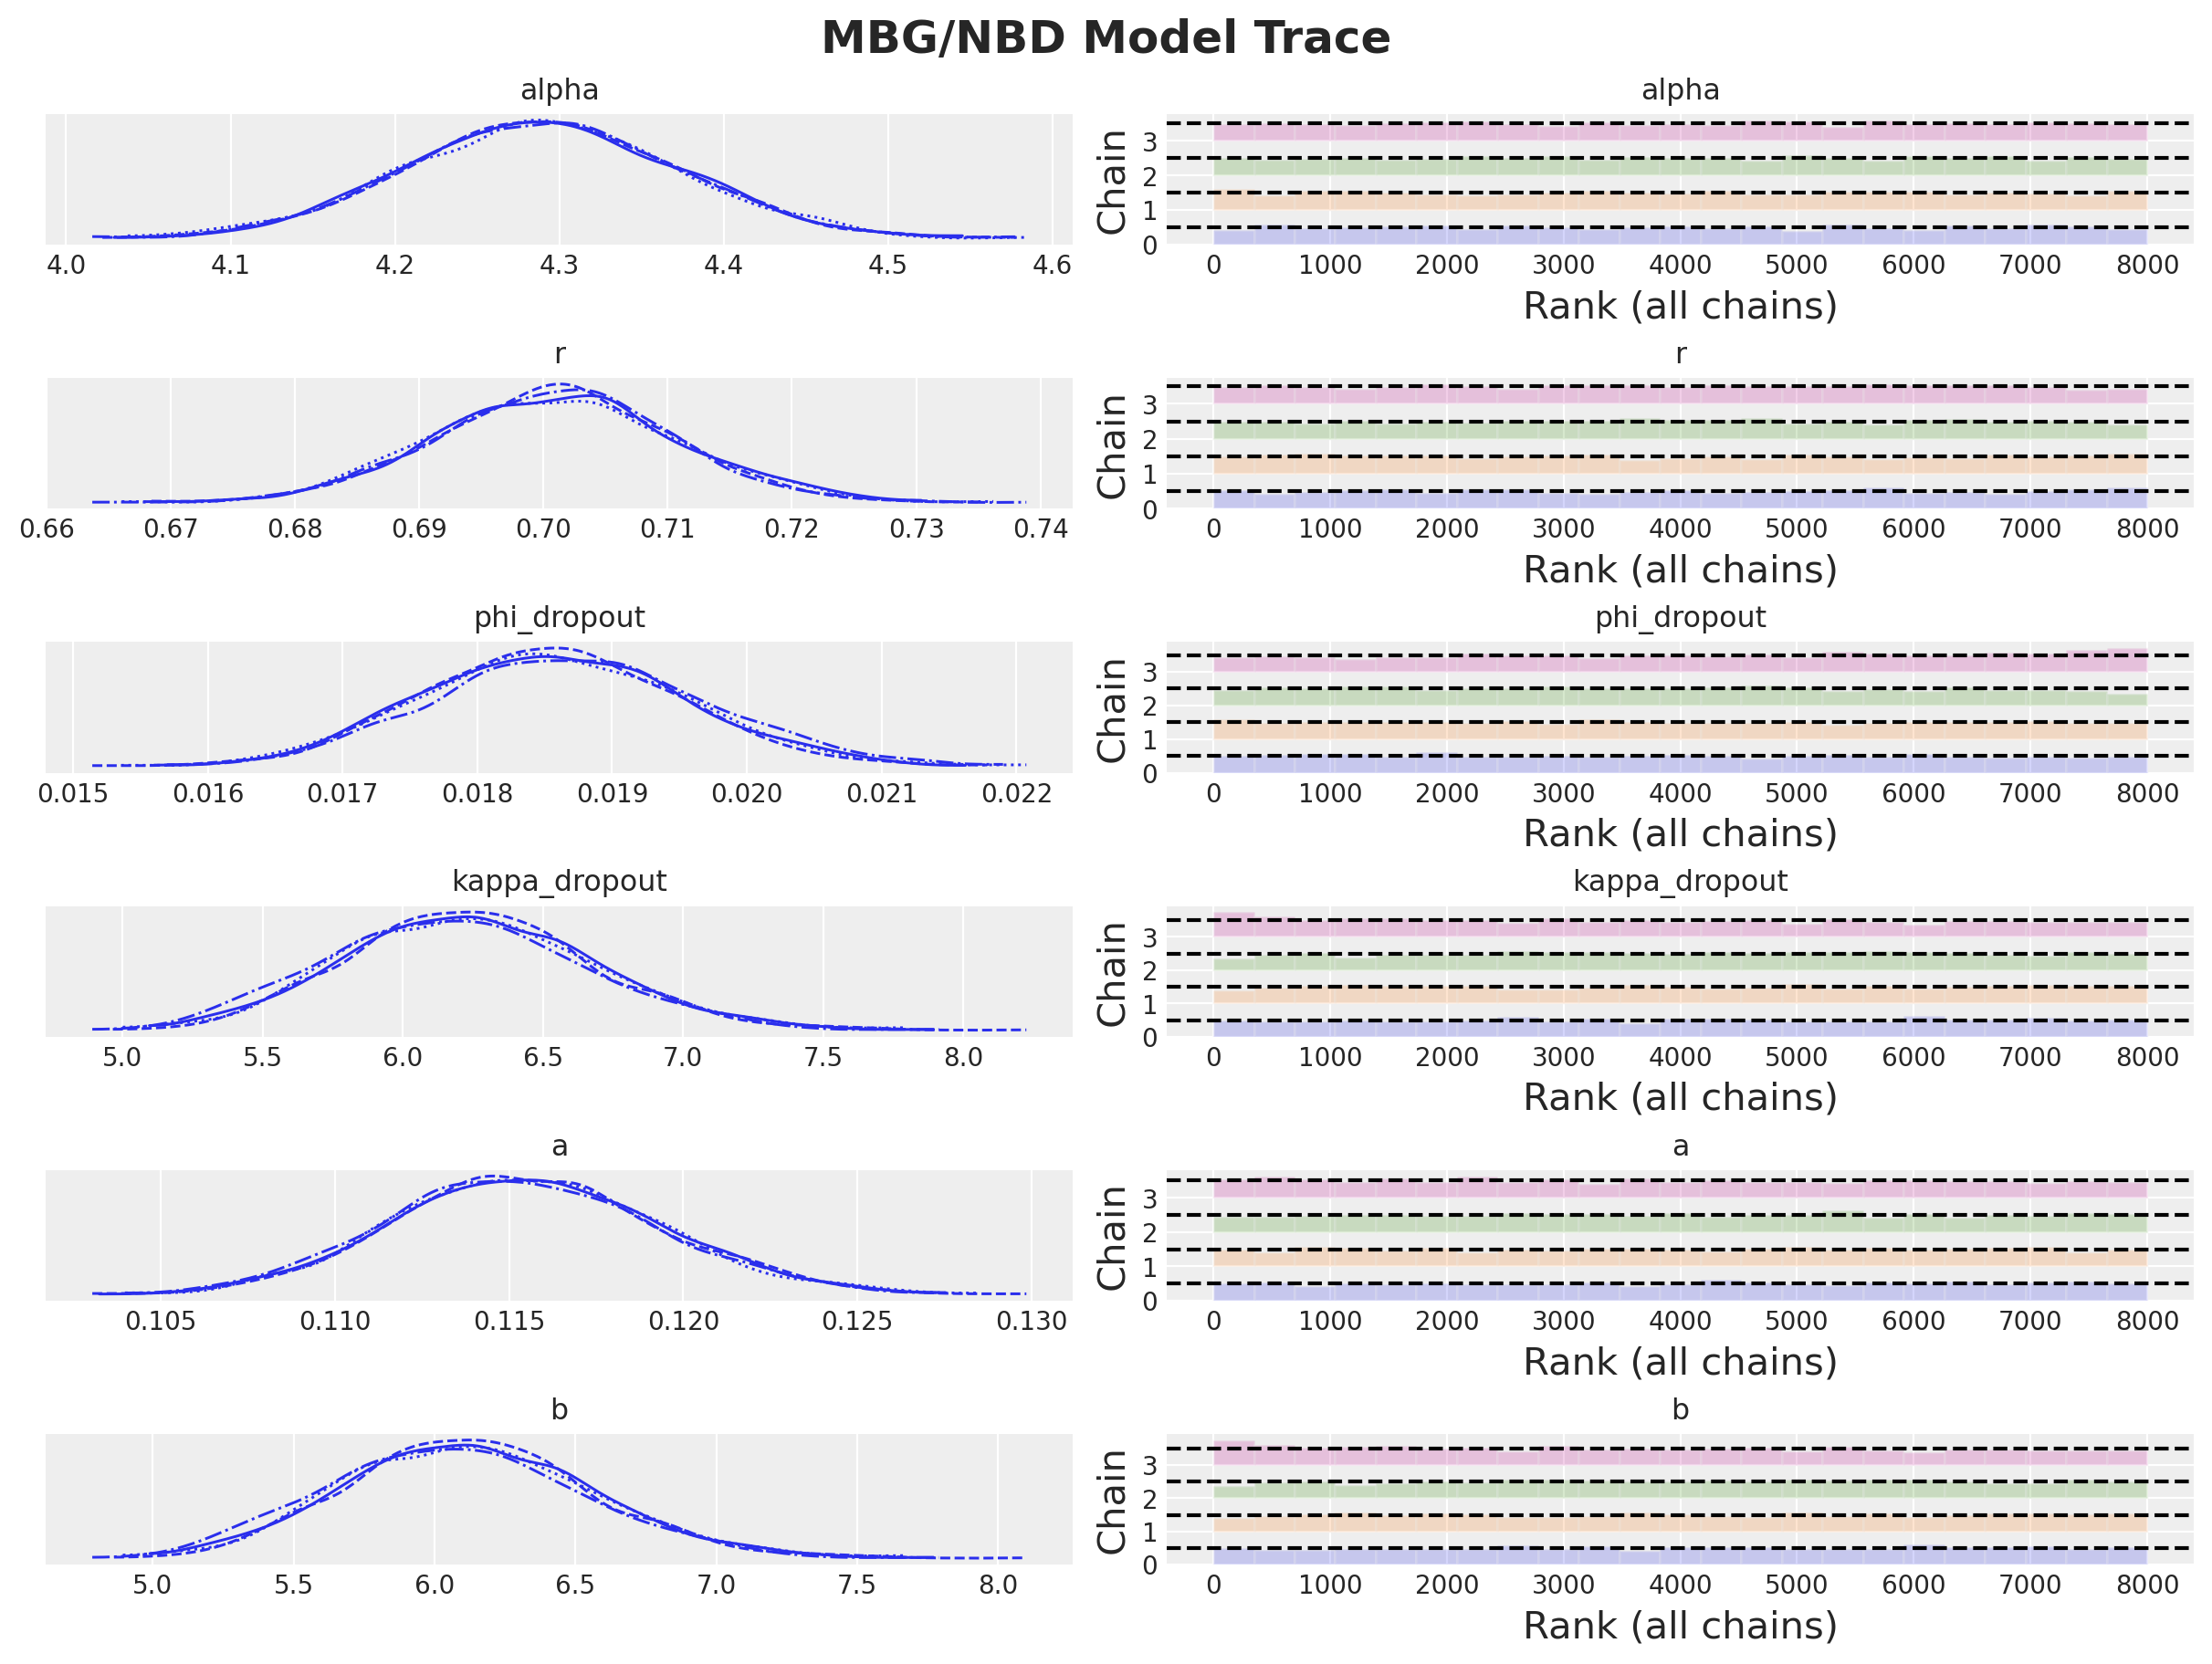

In [73]:
axes = az.plot_trace(
    data=mbgm.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("MBG/NBD Model Trace", fontsize=18, fontweight="bold");

### Using MAP fit

In [74]:
model_map = clv.ModifiedBetaGeoModel(data=data_summary_rfm)
idata_map = model_map.fit(method="map")
idata_map

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [75]:
map_summary = model_map.fit_summary()
map_summary

alpha            4.289
r                0.701
phi_dropout      0.019
kappa_dropout    6.192
a                0.115
b                6.077
Name: value, dtype: float64

### Comparing with the lifetimes package

In [76]:
mbgf = ModifiedBetaGeoFitter()
mbgf.fit(
    frequency=data_summary_rfm["frequency"].values,
    recency=data_summary_rfm["recency"].values,
    T=data_summary_rfm["T"].values,
)

<lifetimes.ModifiedBetaGeoFitter: fitted with 7998 subjects, a: 0.12, alpha: 4.29, b: 6.14, r: 0.70>

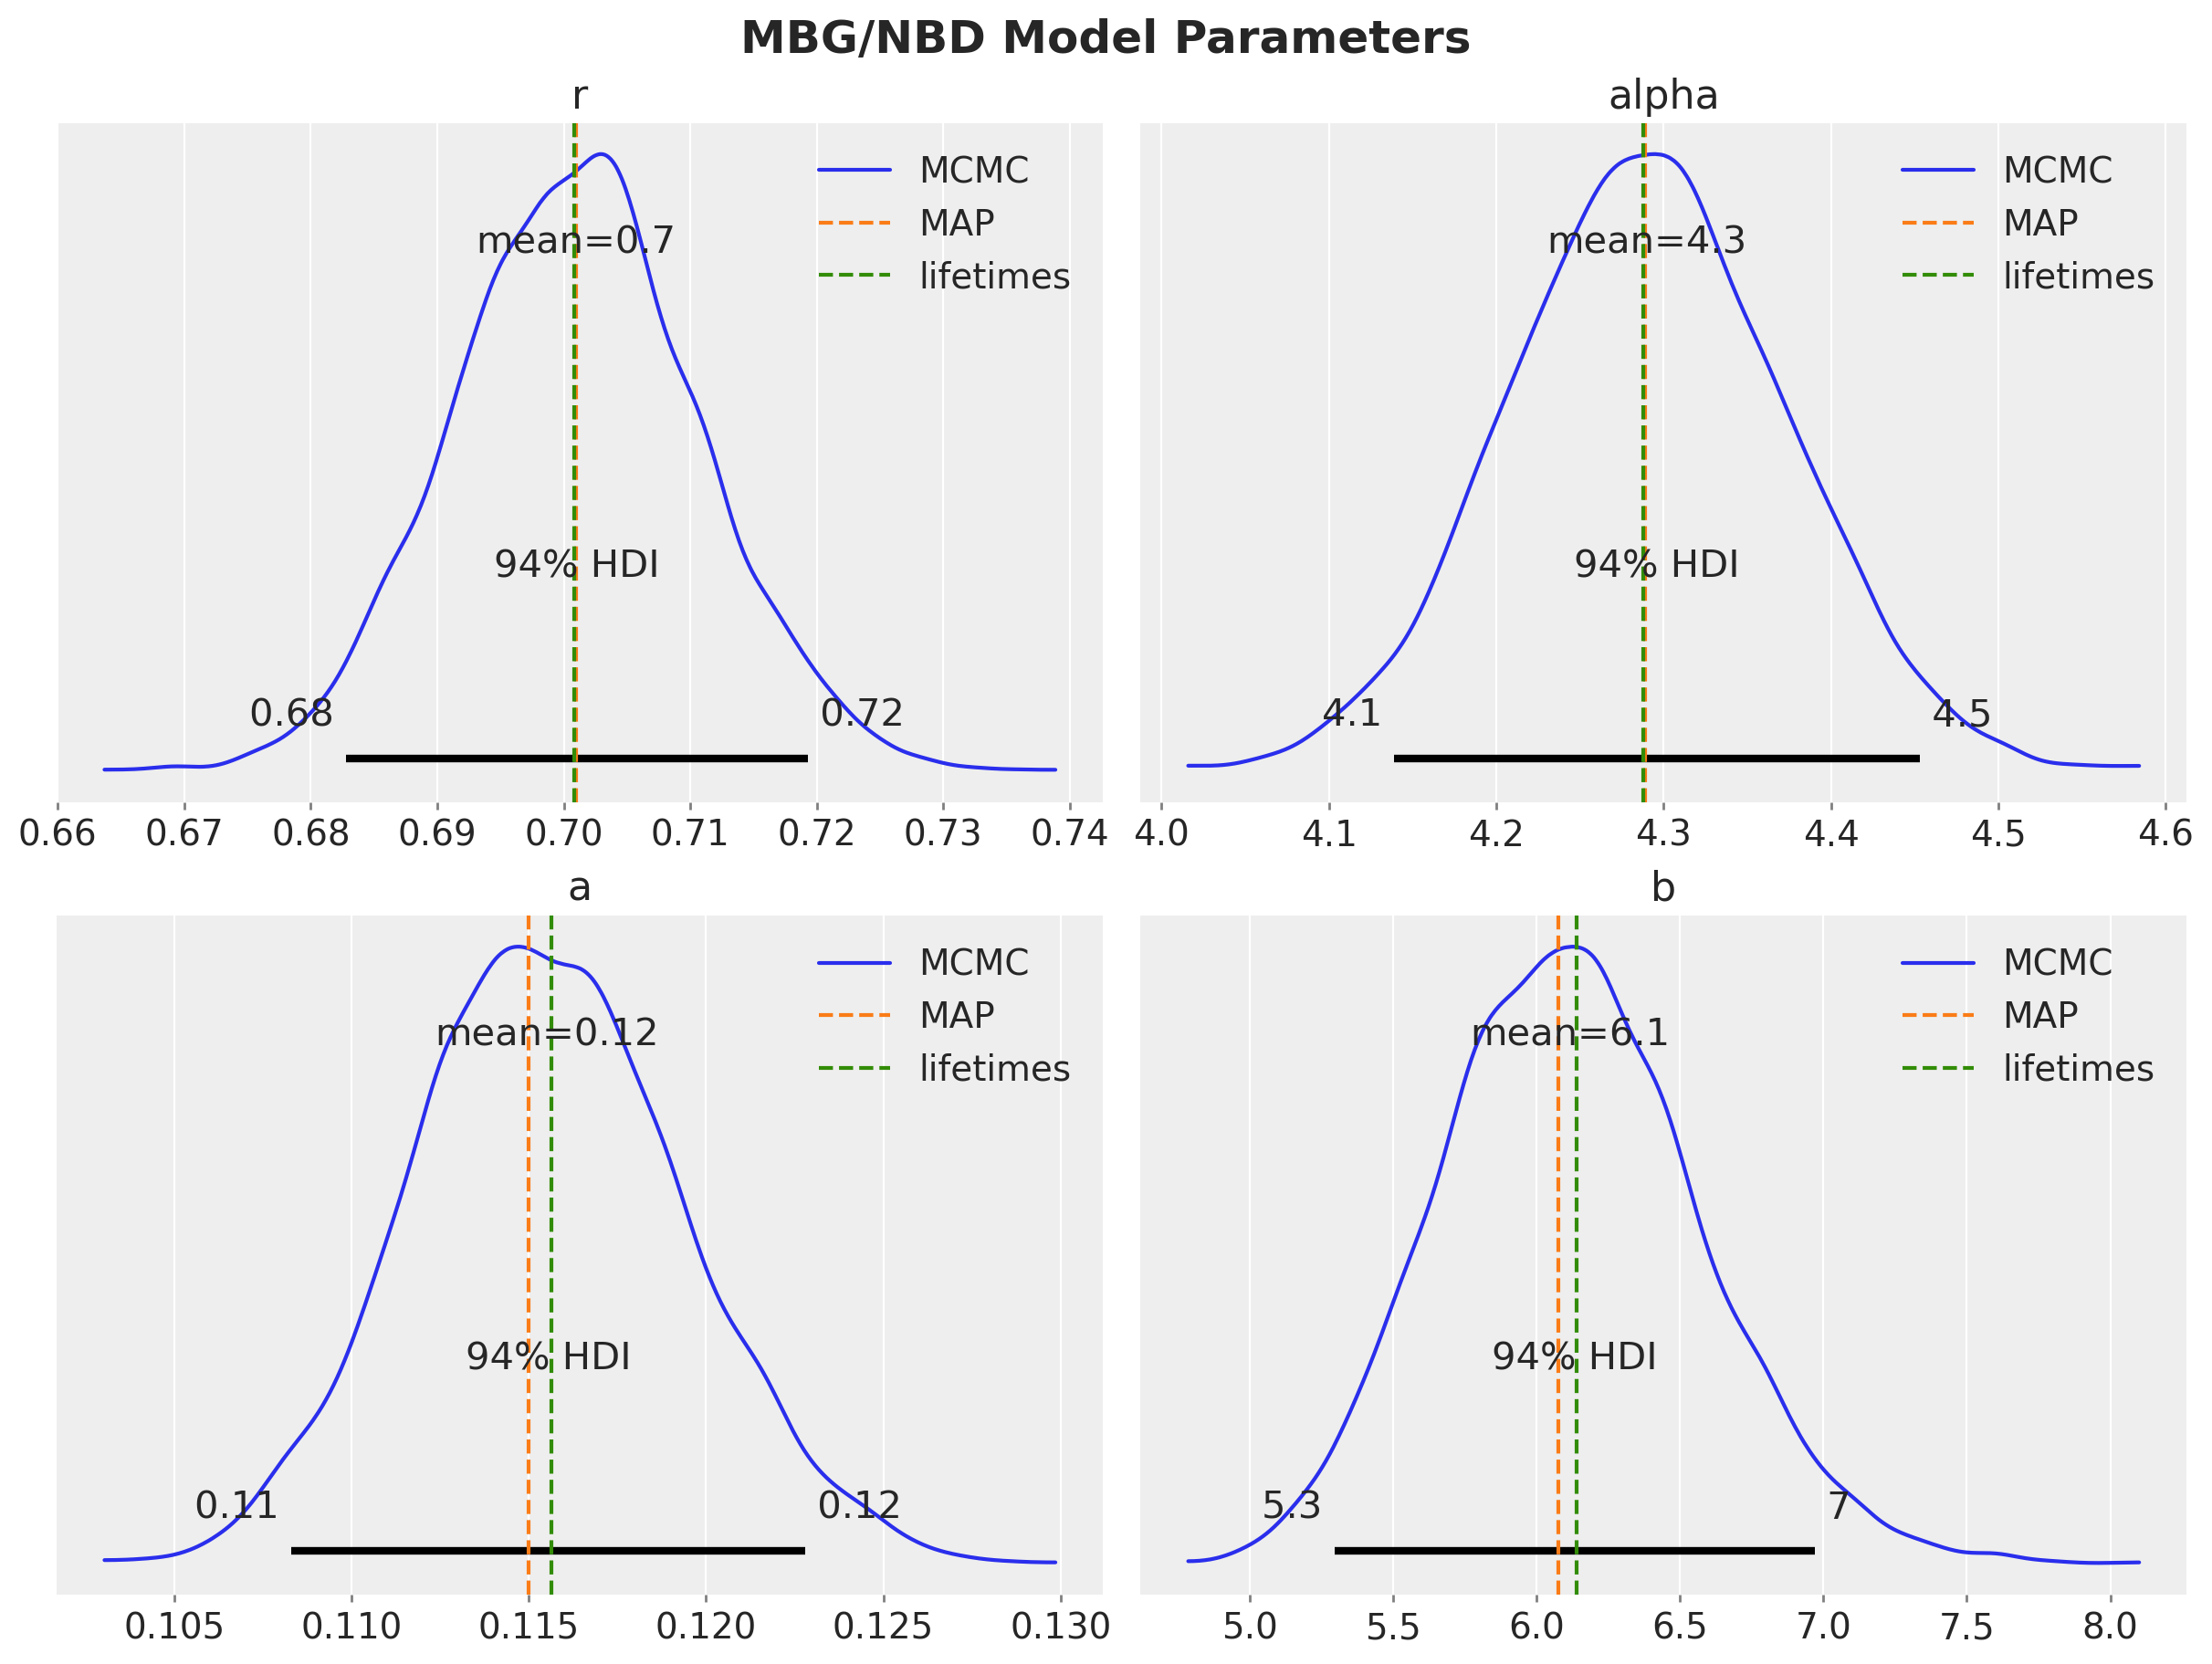

In [77]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "a", "b"]):
    ax = axes[i]
    az.plot_posterior(
        mbgm.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="MCMC",
    )
    ax.axvline(x=map_summary[var_name], color="C1", linestyle="--", label="MAP")
    ax.axvline(
        x=mbgf.summary["coef"][var_name], color="C2", linestyle="--", label="lifetimes"
    )
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("MBG/NBD Model Parameters", fontsize=18, fontweight="bold");

### Prior and Posterior Predictive Checks

Sampling: [alpha, kappa_dropout, phi_dropout, r, recency_frequency]


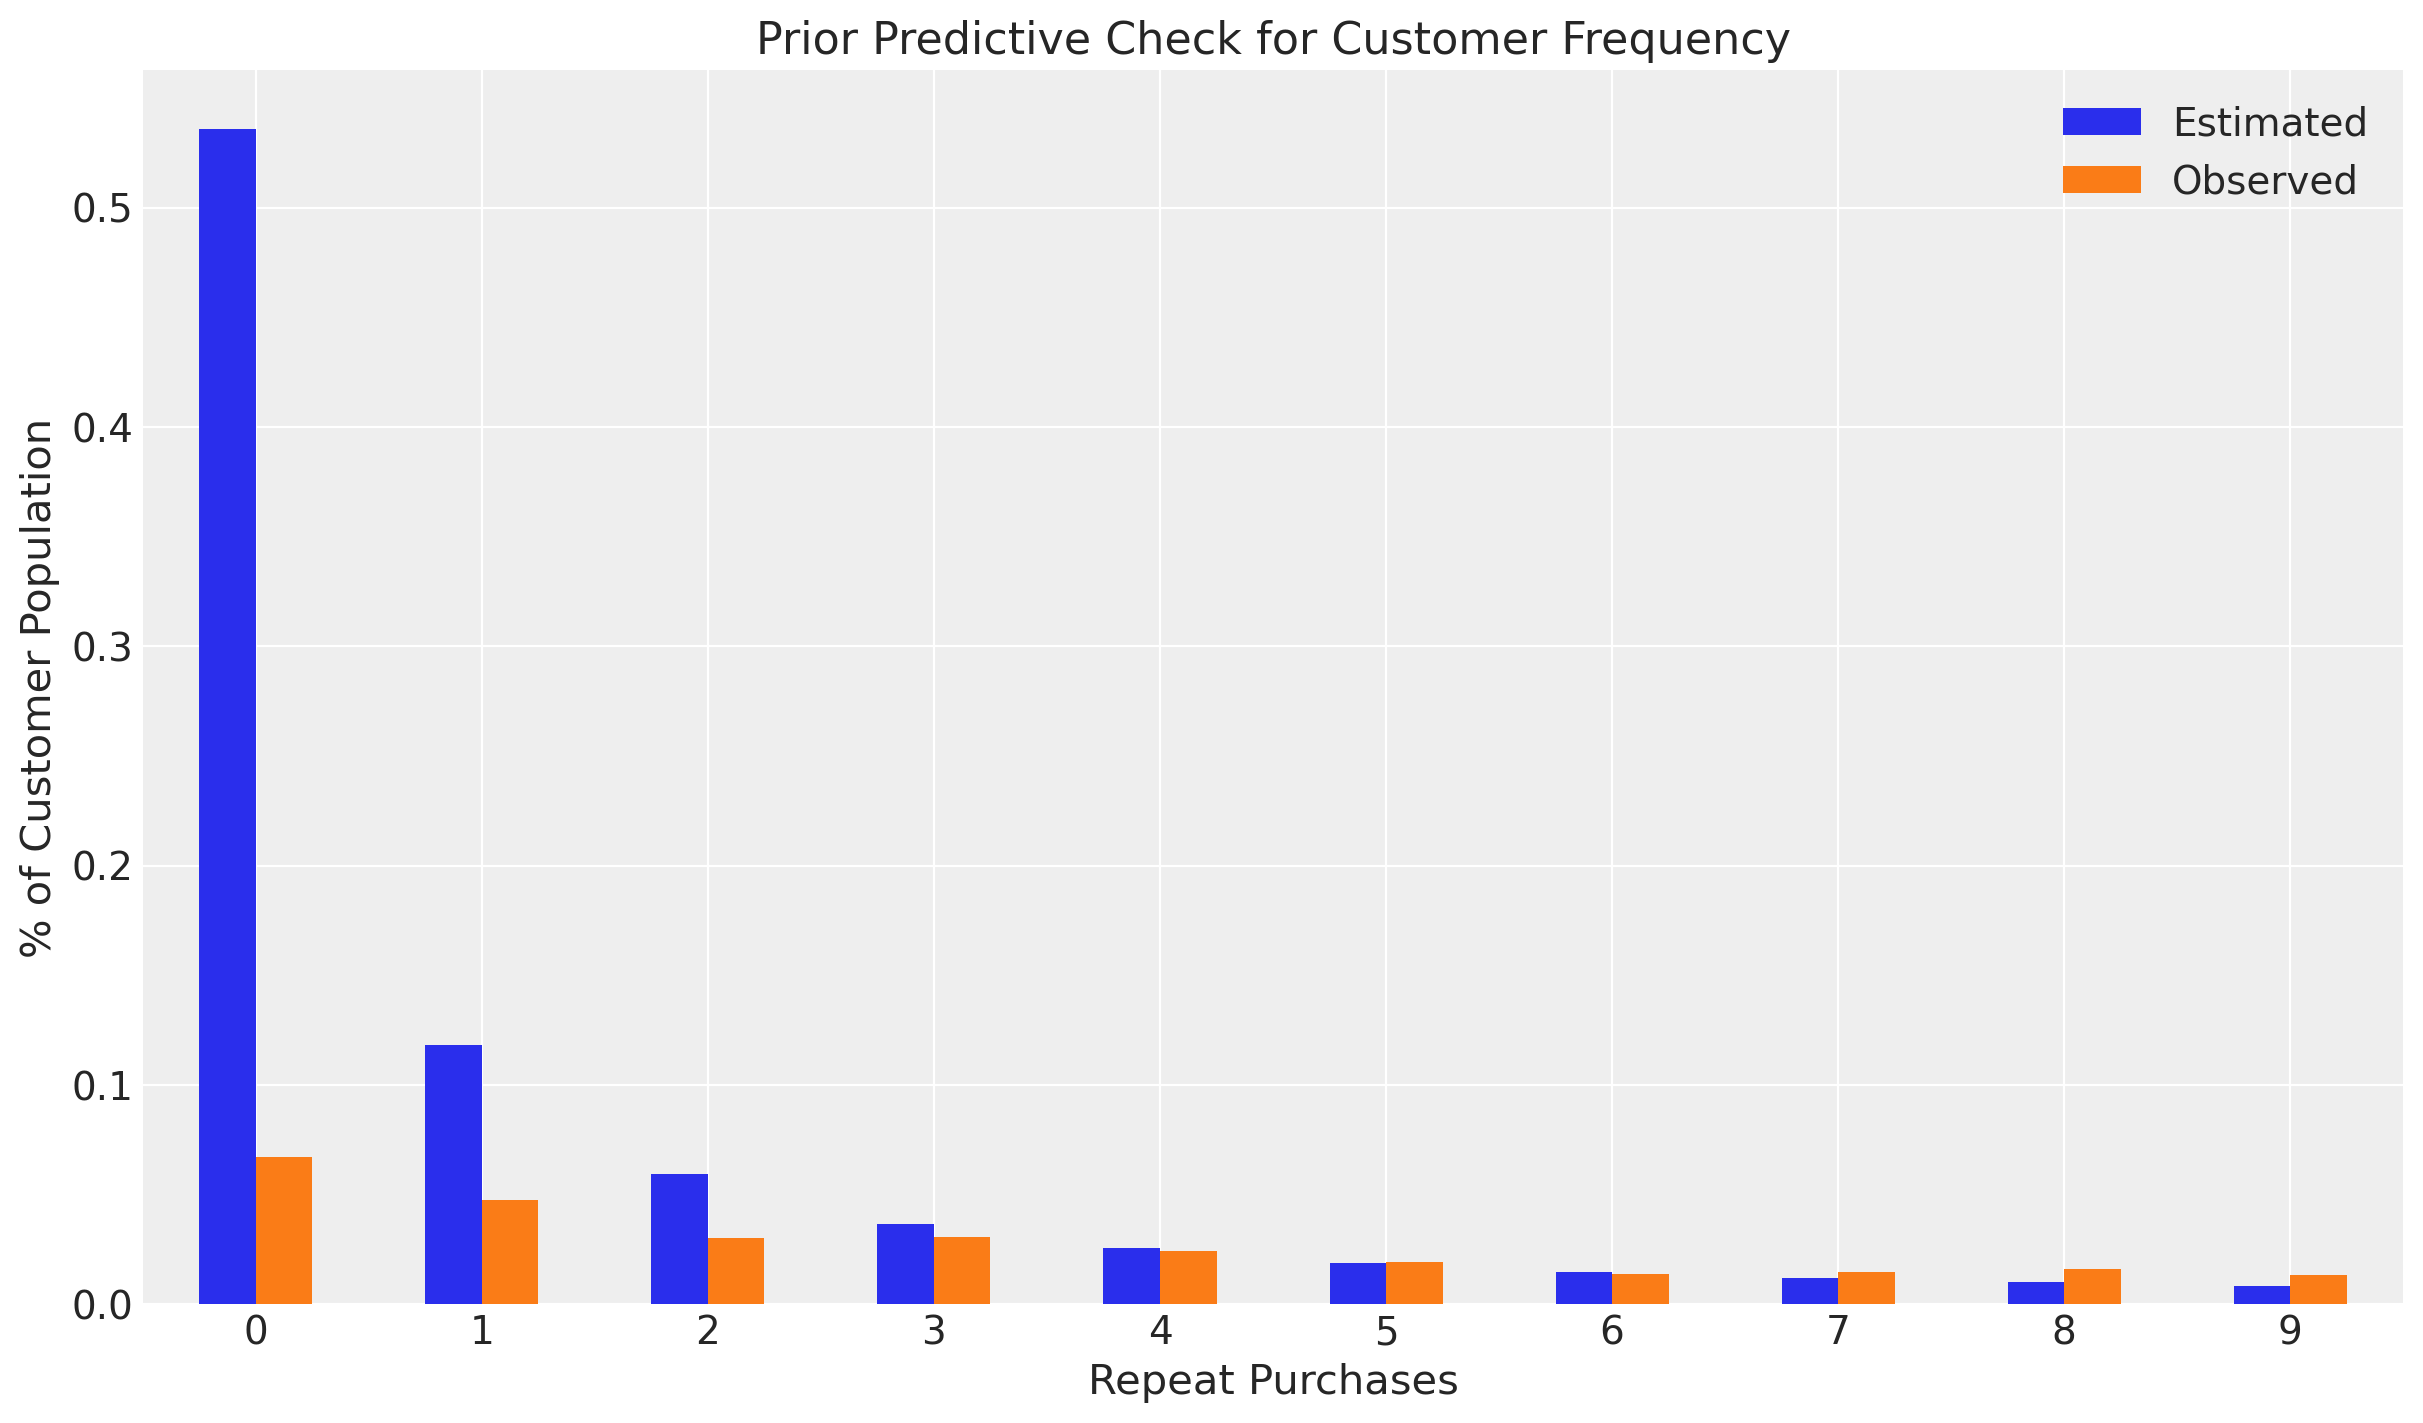

In [78]:
# PPC histogram plot
clv.plot_expected_purchases_ppc(mbgm, ppc="prior");

Sampling: [recency_frequency]


Output()

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x13783ccc0>
Traceback (most recent call last):
  File "/Users/changyu/miniconda3/lib/python3.12/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110222ff0>>
Traceback (most recent call last):
  File "/Users/changyu/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

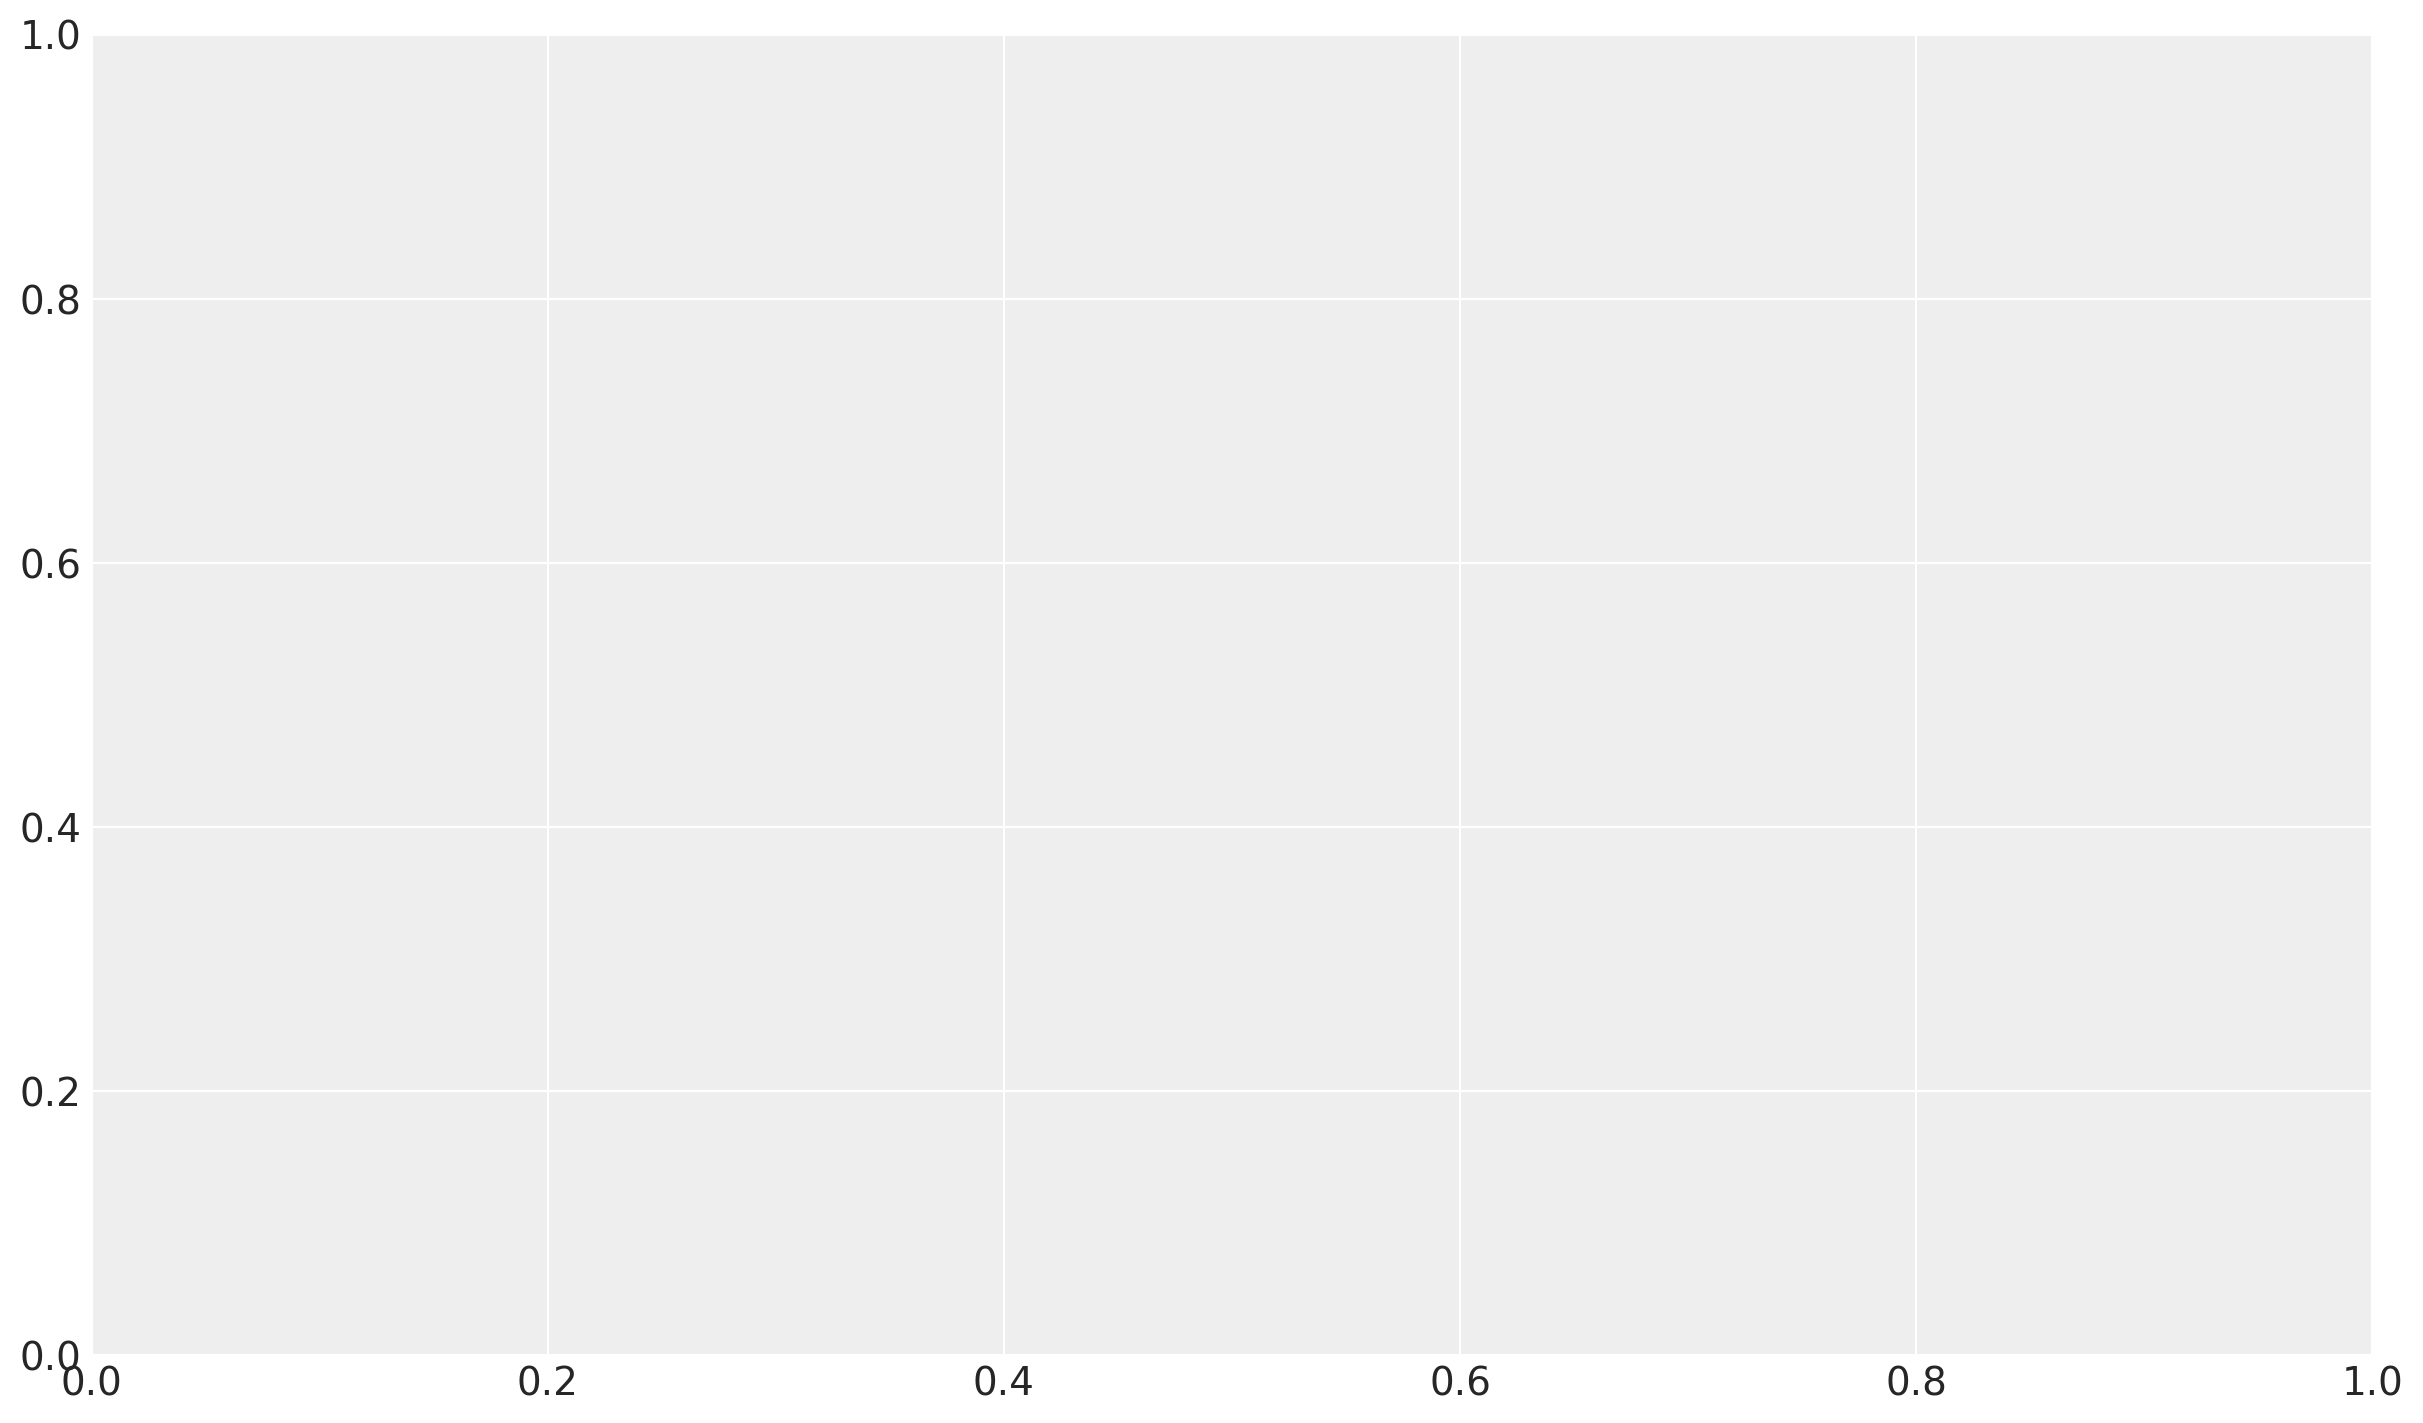

In [79]:
# PPC histogram plot
clv.plot_expected_purchases_ppc(mbgm, ppc="posterior");

### Some Applications

#### Expected Number of Purchases

In [80]:
# example_customer_ids = ['12347', '12348', '12349', '12350', '12351', '12352']

example_customer_ids = [1364781544796422146, 33485, 35036, 33475, 4987, 5039]

data_small = data_summary_rfm.query("customer_id.isin(@example_customer_ids)")

data_small.head(6)

,customer_id,frequency,recency,T,monetary_value
7,4987,884.0,1683.0,1909.0,74.802036
9,5039,4.0,630.0,1243.0,30.000000
639,33475,945.0,2098.0,2098.0,120.121693
640,33485,1786.0,2093.0,2093.0,402.525196
722,35036,1060.0,1344.0,2059.0,427.688679
2967,1364781544796422146,1192.0,1376.0,1376.0,1693.431208


In [89]:
steps = 30

expected_num_purchases_steps = xr.concat(
    objs=[
        mbgm.expected_purchases(
            data=data_small,
            future_t=t,
        )
        for t in progress_bar(range(steps))
    ],
    dim="t",
).transpose(..., "t")

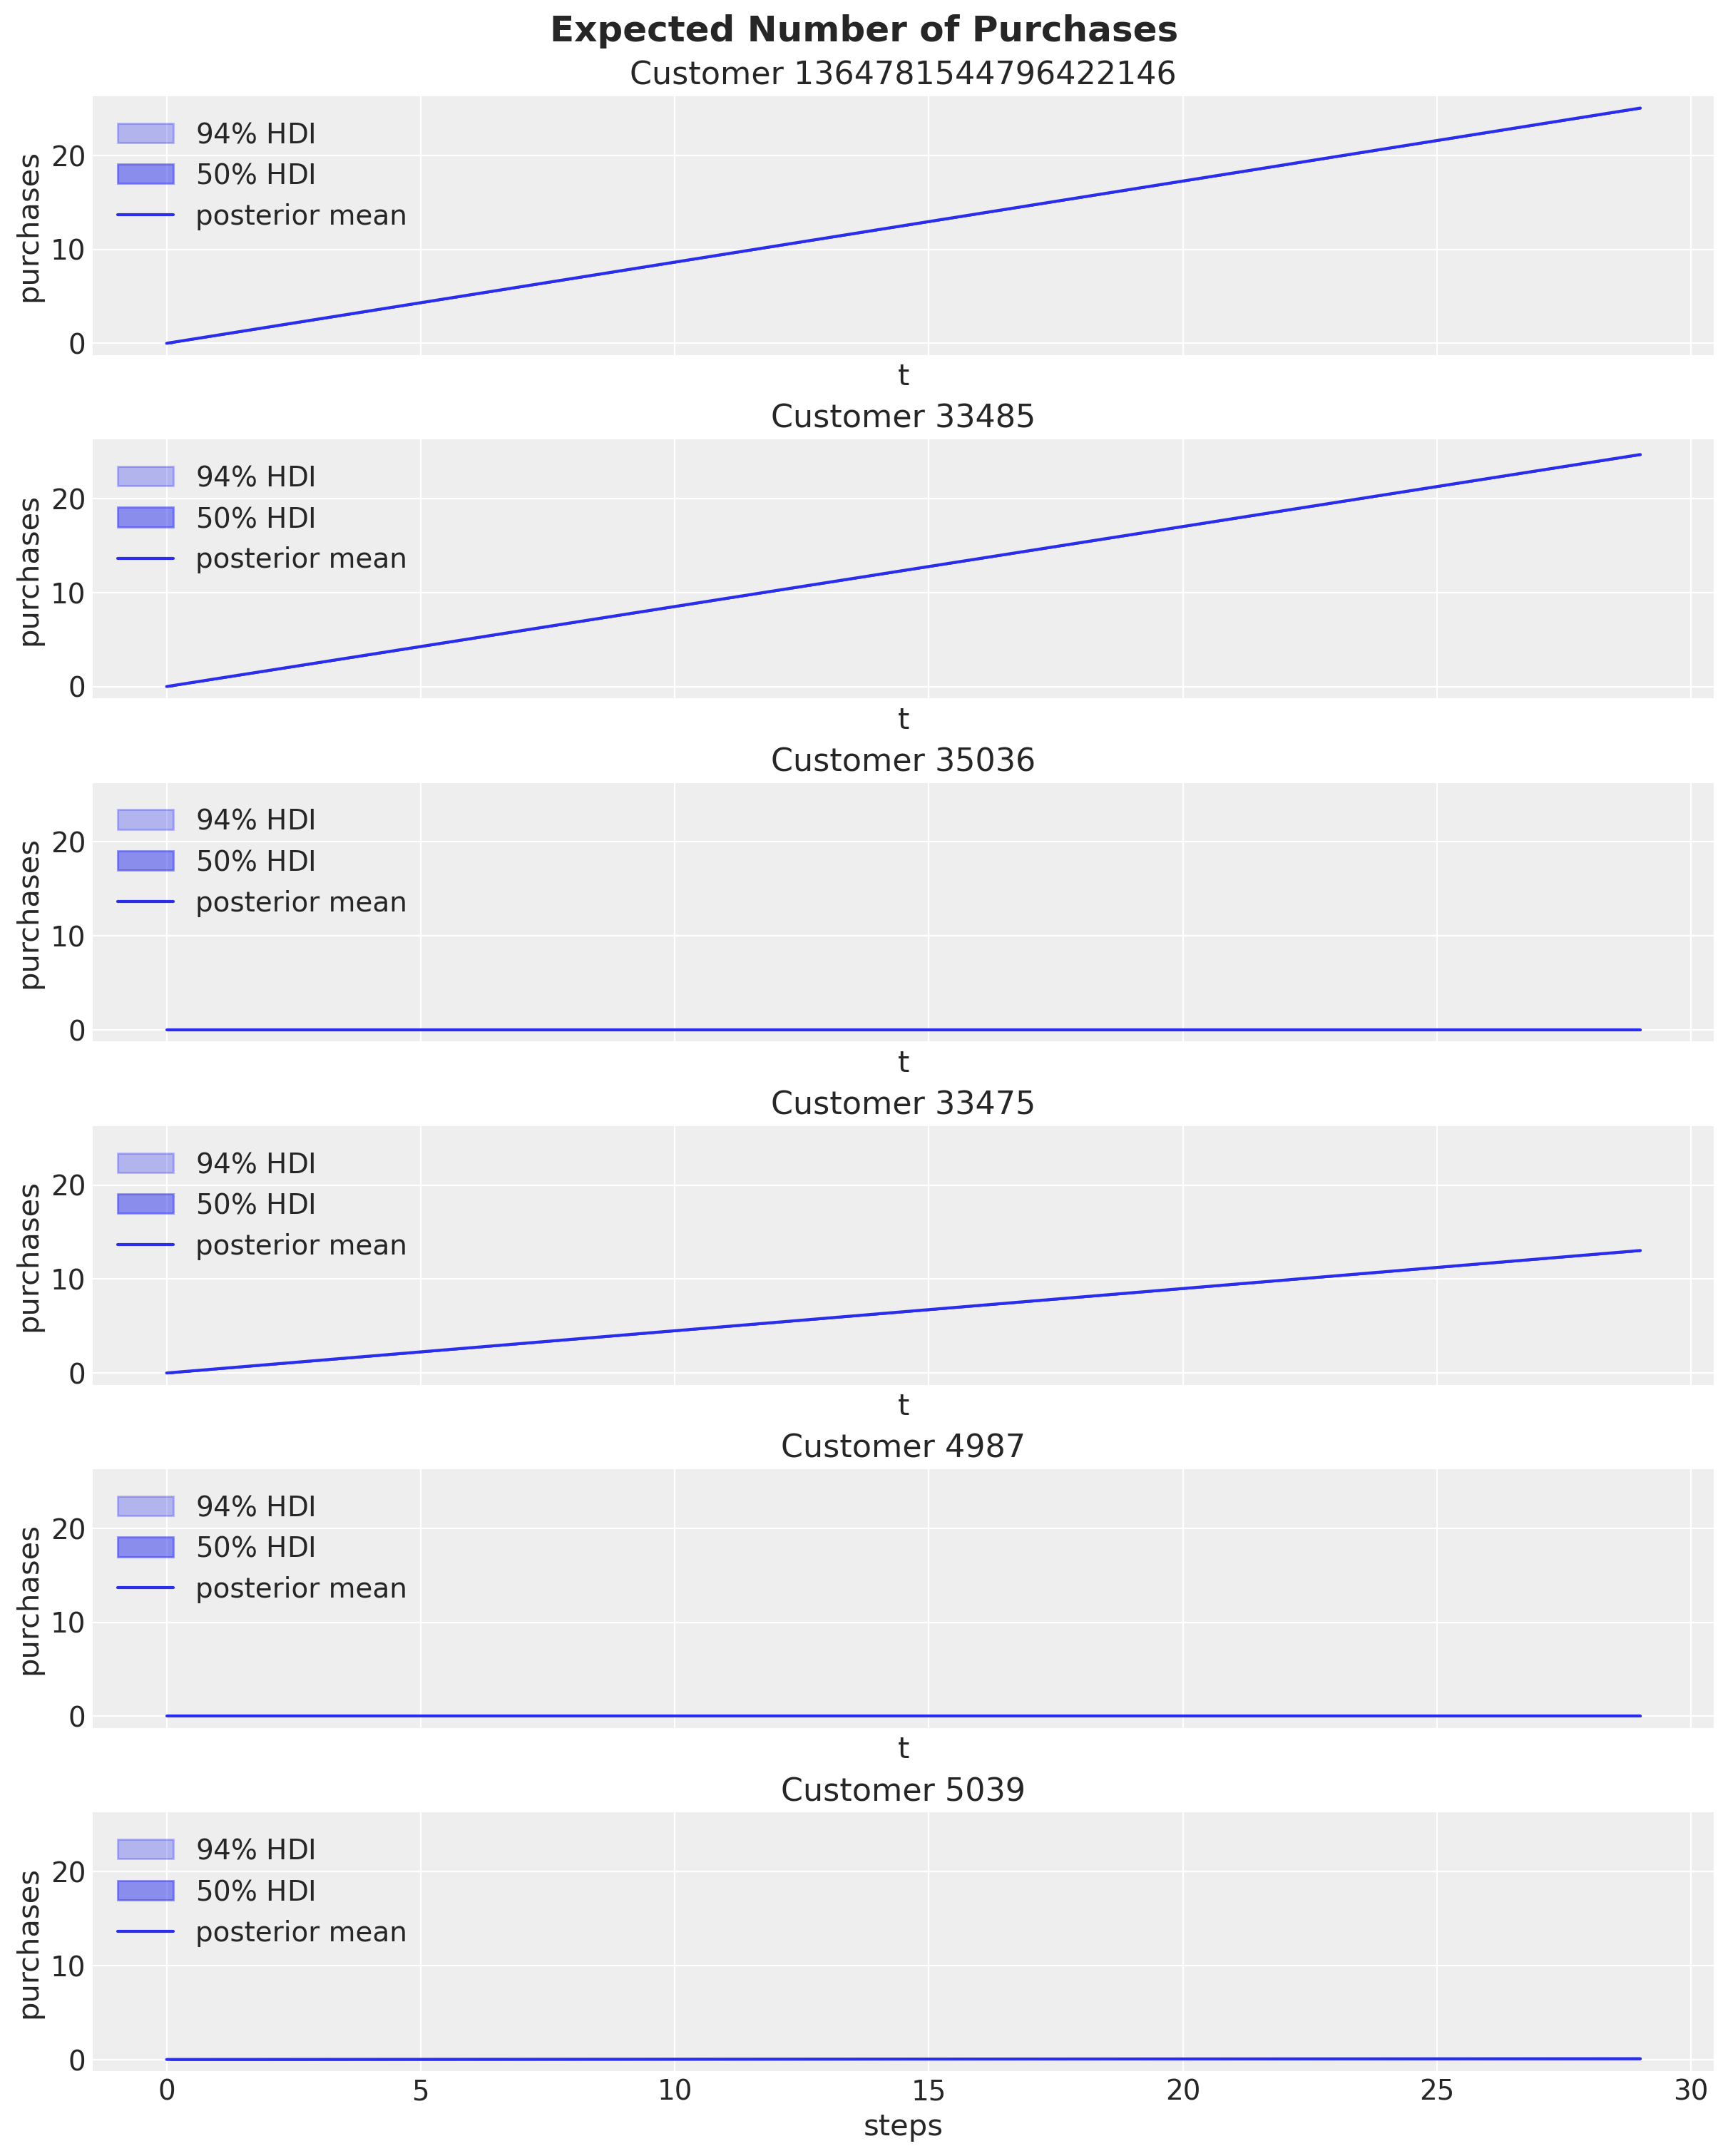

In [90]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_num_purchases_steps = expected_num_purchases_steps.sel(
        customer_id=customer_id,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_num_purchases_steps,
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_num_purchases_steps,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_num_purchases_steps.mean(dim=("chain", "draw")),
        color="C0",
        label="posterior mean",
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Customer {customer_id}", xlabel="t", ylabel="purchases")

axes[-1].set(xlabel="steps")
plt.gcf().suptitle("Expected Number of Purchases", fontsize=18, fontweight="bold");

### Probability of a Customer Being Alive

In [91]:
steps = 30

future_alive_all = []

for t in progress_bar(range(steps)):
    future_data = data_small.copy()
    future_data["T"] = future_data["T"] + t
    future_alive = mbgm.expected_probability_alive(data=future_data)
    future_alive_all.append(future_alive)

expected_probability_alive_steps = xr.concat(
    objs=future_alive_all,
    dim="t",
).transpose(..., "t")

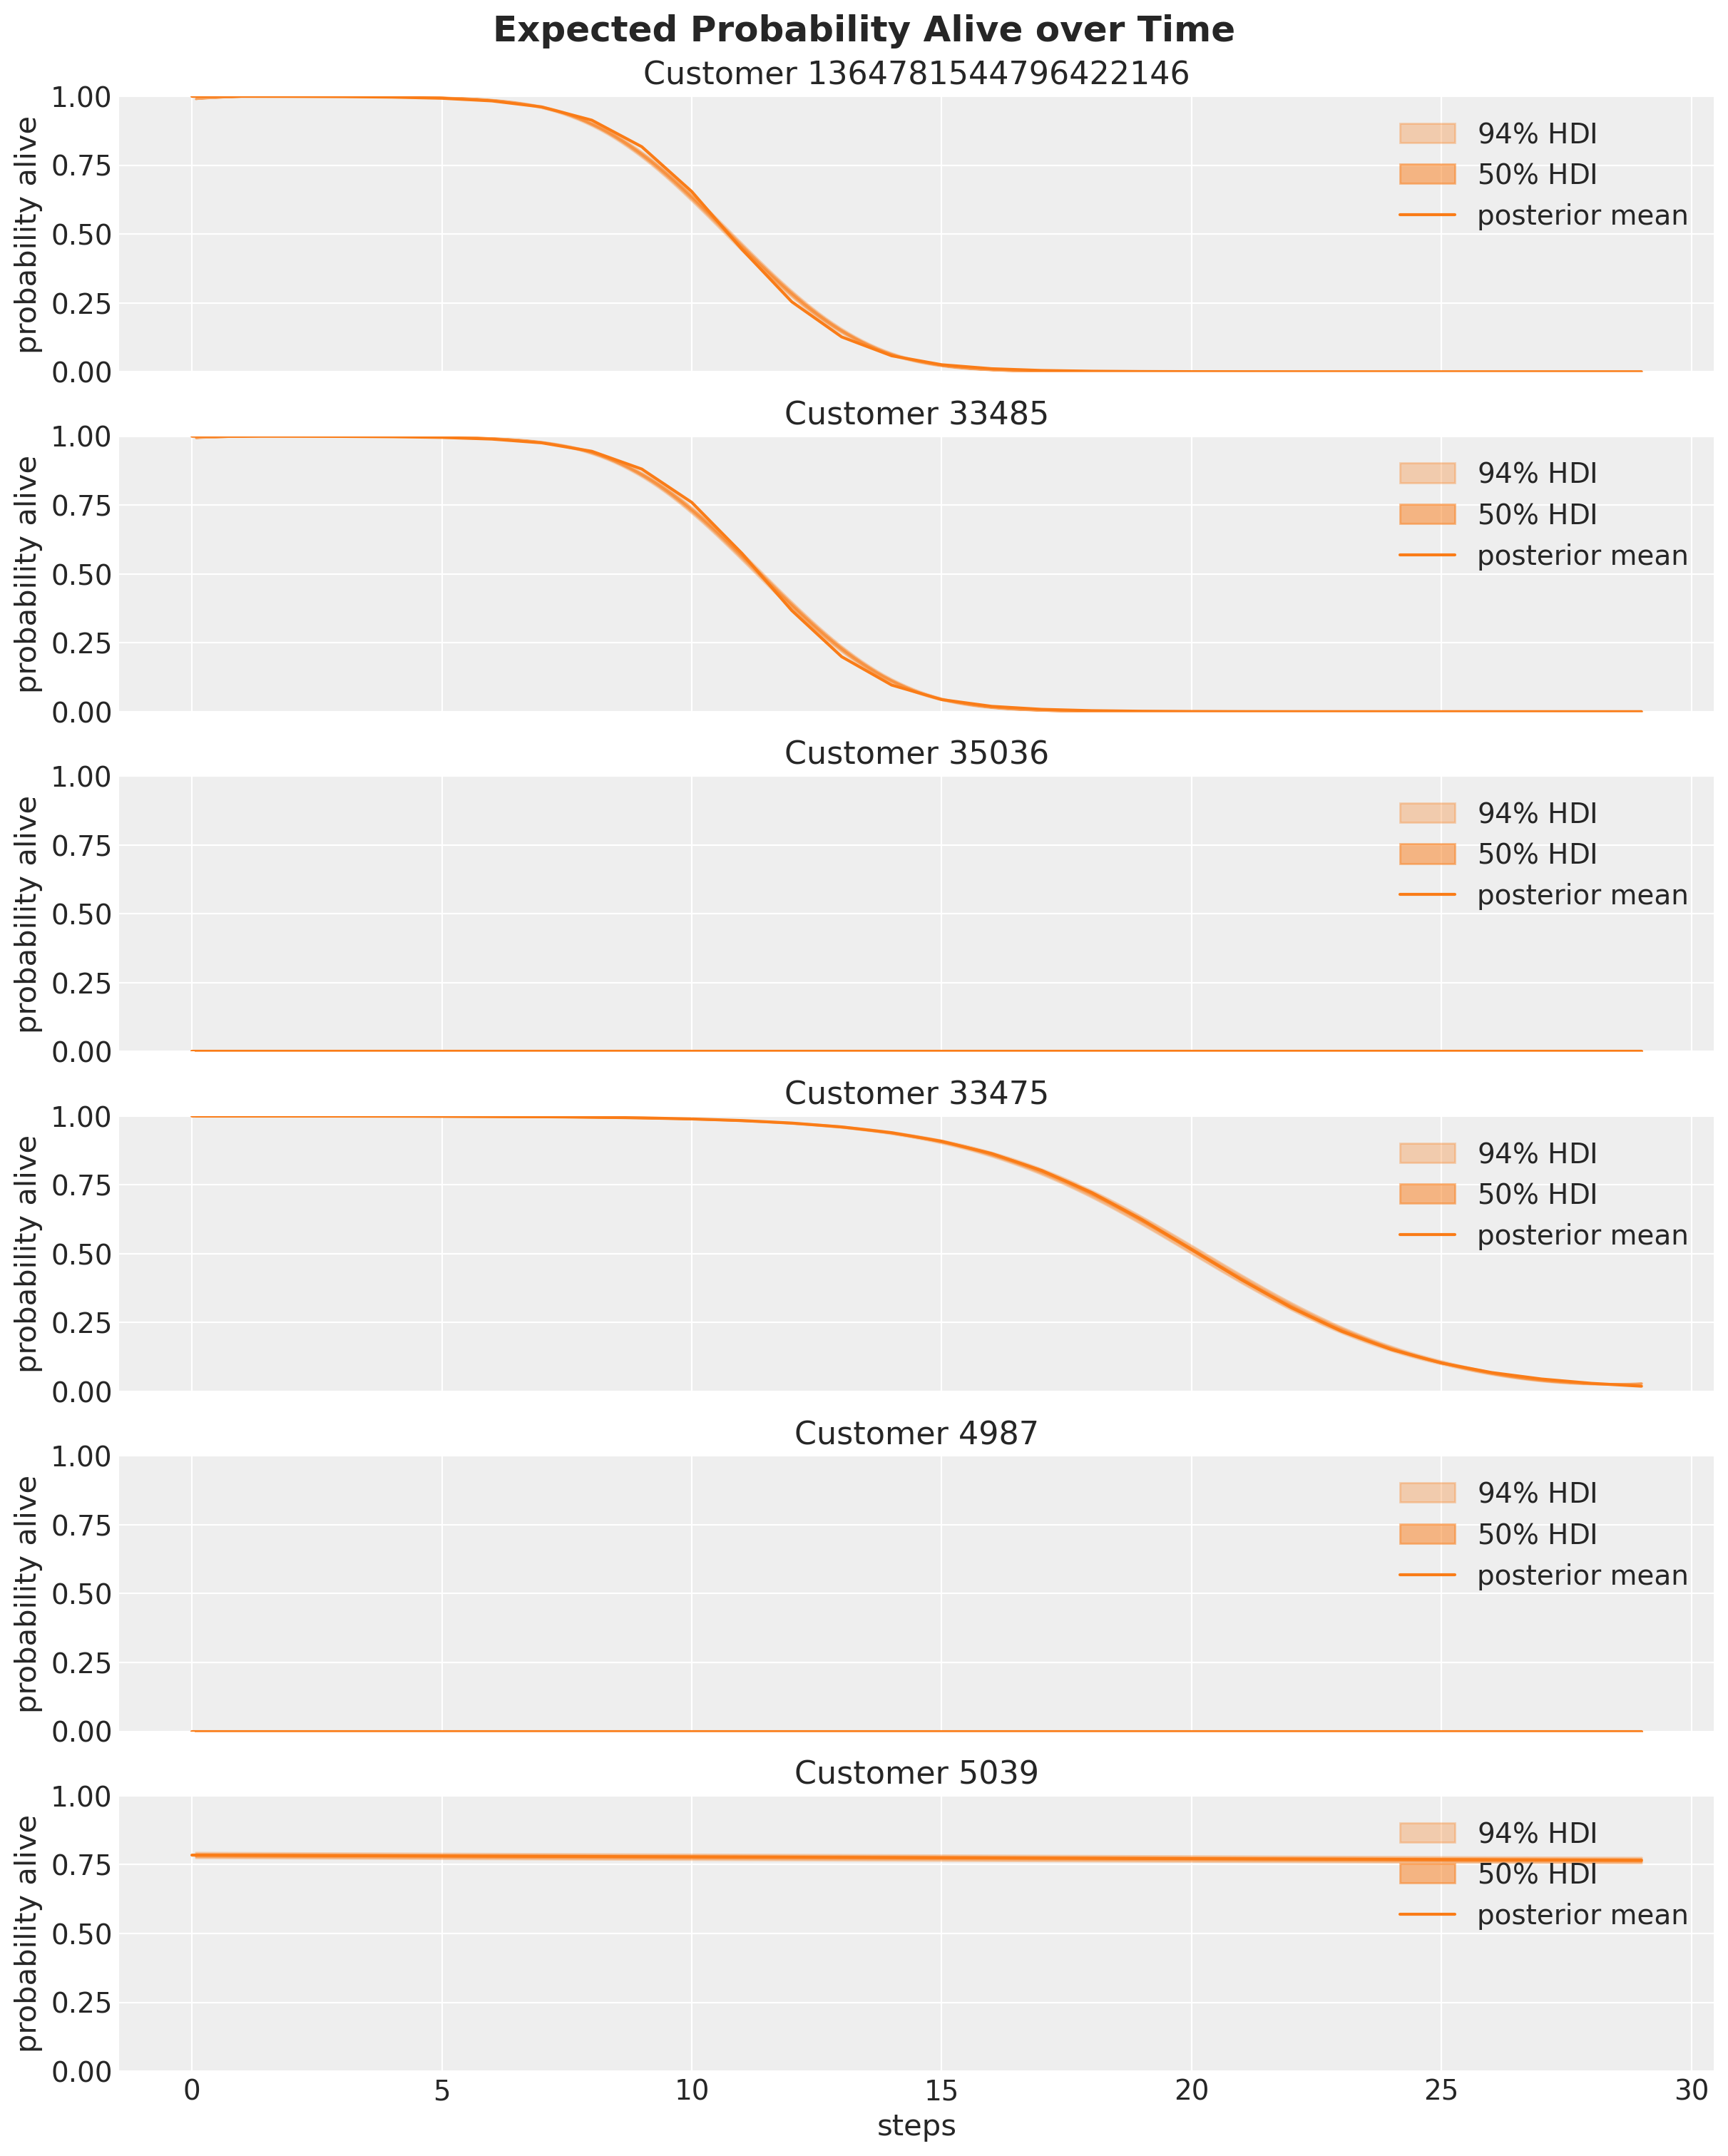

In [92]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_probability_alive_steps = expected_probability_alive_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.5,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_probability_alive_steps.mean(dim=("chain", "draw")),
        color="C1",
        label="posterior mean",
    )
    ax.legend(loc="upper right")
    ax.set(title=f"Customer {customer_id}", ylabel="probability alive", ylim=(0, 1))

axes[-1].set(xlabel="steps")
plt.gcf().suptitle(
    "Expected Probability Alive over Time", fontsize=18, fontweight="bold"
);

In [113]:
%reload_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Tue Jun 17 2025

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 9.3.0

pymc    : 5.23.0
pytensor: 2.31.3

pandas        : 2.2.3
pymc_marketing: 0.14.0
lifetimes     : 0.11.3
sys           : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
arviz         : 0.21.0
requests      : 2.32.3
xarray        : 2025.6.1
numpy         : 2.0.1
pymc          : 5.23.0
IPython       : 9.3.0
matplotlib    : 3.10.0
fastprogress  : 1.0.0

Watermark: 2.5.0

